In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class CauchyActivation(nn.Module):
    def __init__(self):
        super().__init__()

        # Initializing λ1, λ2, d as trainable parameters
        self.lambda1 = nn.Parameter(torch.tensor(1.0))
        self.lambda2 = nn.Parameter(torch.tensor(1.0))
        self.d = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        x2_d2 = x ** 2 + self.d ** 2
        return self.lambda1 * x / x2_d2 + self.lambda2 / x2_d2

# Class representing an MLP architecture


class NeuralNetwork(nn.Module):
    def __init__(self, activation_function1, activation_function2):
        super().__init__()

        self.activation_function1 = activation_function1
        self.activation_function2 = activation_function2
        # Defining neural network layers
        # (no. of hidden layer nodes is not mentioned in the original research paper)
        self.input_layer = nn.Linear(784, 128)
        self.hidden_layer = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, x):
        # Transforming 2D image to 1D vector
        x = x.view(-1, 28*28)

        x = self.input_layer(x)
        x = self.activation_function1(x)
        x = self.hidden_layer(x)
        x = self.activation_function2(x)
        x = self.output_layer(x)

        return x


In [5]:
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += target.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total_samples

    return avg_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            batch_loss = criterion(output, target).item()
            test_loss += batch_loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total_samples += target.size(0)

    test_loss /= len(test_loader)
    accuracy = 100. * correct / total_samples

    return test_loss, accuracy


In [6]:
# Seting device to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Defining transformations
transform = transforms.Compose([transforms.ToTensor()])

# Loading datasets
train_dataset = datasets.MNIST(
    './data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)


cpu


In [7]:
# Instantiating models
relu_model = NeuralNetwork(
    activation_function1=nn.ReLU(), activation_function2=nn.ReLU()).to(device)
cauchy_activation1 = CauchyActivation()
cauchy_activation2 = CauchyActivation()
x_net = NeuralNetwork(activation_function1=cauchy_activation1,
                      activation_function2=cauchy_activation2).to(device)


In [8]:
# Defining loss function
criterion = nn.CrossEntropyLoss()

# Define optimizers (Learning rate is used as per the original research paper)
relu_optimizer = optim.Adam(relu_model.parameters(), lr=0.0001)
cauchy_optimizer = optim.Adam(x_net.parameters(), lr=0.0001)


In [9]:
def plot_activation_function(lambda1, lambda2, d):
    print("λ1 = {} λ2 = {} d = {}".format(lambda1,lambda2, d))
    x = np.arange(-10,10,0.01)
    x2_d2 = x ** 2 + d ** 2
    f = (lambda1 * x / x2_d2) + (lambda2 / x2_d2)
    plt.plot(x, f, '-kx')

λ1 = 1.0 λ2 = 1.0 d = 1.0


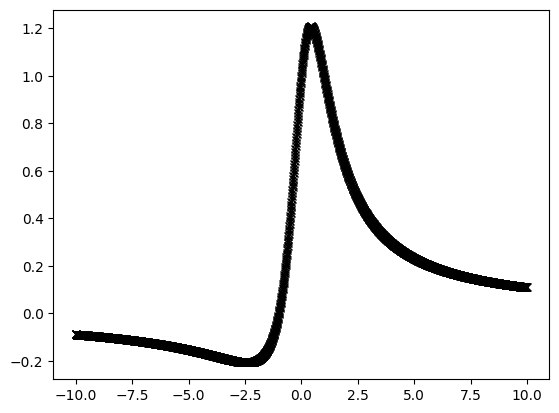

In [34]:
plot_activation_function(x_net.activation_function1.lambda1.item(), x_net.activation_function1.lambda2.item(), x_net.activation_function1.d.item())

In [10]:
# Training the networks

# Lists for storing metrics
relu_train_losses, relu_train_accuracies = [], []
relu_val_losses, relu_val_accuracies = [], []
cauchy_train_losses, cauchy_train_accuracies = [], []
cauchy_val_losses, cauchy_val_accuracies = [], []

# Training loop for both models
epochs = 10
print("Training ReLU Model:")
for epoch in range(1, epochs + 1):
    relu_train_loss, relu_train_acc = train(
        relu_model, device, train_loader, relu_optimizer)
    relu_val_loss, relu_val_acc = test(relu_model, device, val_loader)
    relu_train_losses.append(relu_train_loss)
    relu_train_accuracies.append(relu_train_acc)
    relu_val_losses.append(relu_val_loss)
    relu_val_accuracies.append(relu_val_acc)
    print(f'Epoch {epoch:02d} - ReLU - Training Loss: {relu_train_loss:.6f}, Training Acc: {relu_train_acc:.2f}%, Validation Loss: {relu_val_loss:.6f}, Validation Acc: {relu_val_acc:.2f}%')

print("\nTraining XNet:")
for epoch in range(1, epochs + 1):
    cauchy_train_loss, cauchy_train_acc = train(
        x_net, device, train_loader, cauchy_optimizer)
    cauchy_val_loss, cauchy_val_acc = test(x_net, device, val_loader)
    cauchy_train_losses.append(cauchy_train_loss)
    cauchy_train_accuracies.append(cauchy_train_acc)
    cauchy_val_losses.append(cauchy_val_loss)
    cauchy_val_accuracies.append(cauchy_val_acc)
    print(f'Epoch {epoch:02d} - Cauchy - Training Loss: {cauchy_train_loss:.6f}, Training Acc: {cauchy_train_acc:.2f}%, Validation Loss: {cauchy_val_loss:.6f}, Validation Acc: {cauchy_val_acc:.2f}%')


Training ReLU Model:


Epoch 01 - ReLU - Training Loss: 0.810072, Training Acc: 79.79%, Validation Loss: 0.343528, Validation Acc: 90.89%


Epoch 02 - ReLU - Training Loss: 0.312819, Training Acc: 91.23%, Validation Loss: 0.268585, Validation Acc: 92.37%


Epoch 03 - ReLU - Training Loss: 0.259542, Training Acc: 92.64%, Validation Loss: 0.233211, Validation Acc: 93.26%


Epoch 04 - ReLU - Training Loss: 0.226905, Training Acc: 93.50%, Validation Loss: 0.209376, Validation Acc: 93.94%


Epoch 05 - ReLU - Training Loss: 0.201754, Training Acc: 94.26%, Validation Loss: 0.189775, Validation Acc: 94.41%


Epoch 06 - ReLU - Training Loss: 0.182419, Training Acc: 94.80%, Validation Loss: 0.173361, Validation Acc: 95.03%


Epoch 07 - ReLU - Training Loss: 0.166515, Training Acc: 95.28%, Validation Loss: 0.159772, Validation Acc: 95.21%


Epoch 08 - ReLU - Training Loss: 0.152317, Training Acc: 95.63%, Validation Loss: 0.147122, Validation Acc: 95.65%


Epoch 09 - ReLU - Training Loss: 0.140184, Training Acc: 95.93%, Validation Loss: 0.139527, Validation Acc: 95.75%


Epoch 10 - ReLU - Training Loss: 0.129547, Training Acc: 96.26%, Validation Loss: 0.133466, Validation Acc: 95.93%

Training XNet:


Epoch 01 - Cauchy - Training Loss: 0.873721, Training Acc: 80.96%, Validation Loss: 0.340876, Validation Acc: 91.49%


Epoch 02 - Cauchy - Training Loss: 0.271532, Training Acc: 92.48%, Validation Loss: 0.214218, Validation Acc: 93.65%


Epoch 03 - Cauchy - Training Loss: 0.182167, Training Acc: 94.68%, Validation Loss: 0.156674, Validation Acc: 95.37%


Epoch 04 - Cauchy - Training Loss: 0.132925, Training Acc: 96.06%, Validation Loss: 0.124001, Validation Acc: 96.29%


Epoch 05 - Cauchy - Training Loss: 0.101212, Training Acc: 96.94%, Validation Loss: 0.104614, Validation Acc: 96.85%


Epoch 06 - Cauchy - Training Loss: 0.078948, Training Acc: 97.64%, Validation Loss: 0.093937, Validation Acc: 97.15%


Epoch 07 - Cauchy - Training Loss: 0.062428, Training Acc: 98.11%, Validation Loss: 0.087100, Validation Acc: 97.39%


Epoch 08 - Cauchy - Training Loss: 0.049557, Training Acc: 98.49%, Validation Loss: 0.083141, Validation Acc: 97.41%


Epoch 09 - Cauchy - Training Loss: 0.038361, Training Acc: 98.91%, Validation Loss: 0.081978, Validation Acc: 97.54%


Epoch 10 - Cauchy - Training Loss: 0.029215, Training Acc: 99.17%, Validation Loss: 0.083980, Validation Acc: 97.74%


Text(0.5, 1.0, 'Training Accuracy Comparison')

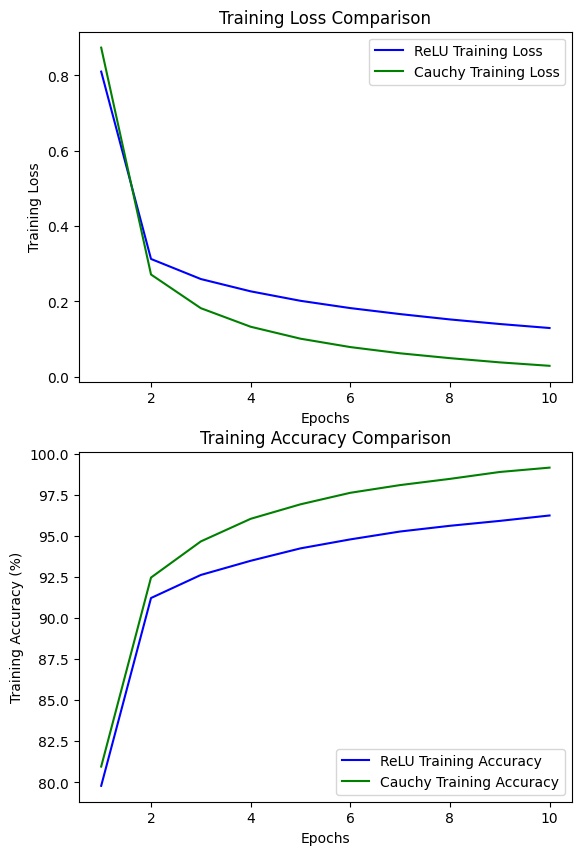

In [11]:
# Plotting the results
# Plotting metrics
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 10))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, relu_train_losses, 'b-', label='ReLU Training Loss')
plt.plot(epochs_range, cauchy_train_losses, 'g-', label='Cauchy Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Comparison')

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs_range, relu_train_accuracies,
         'b-', label='ReLU Training Accuracy')
plt.plot(epochs_range, cauchy_train_accuracies,
         'g-', label='Cauchy Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.legend()
plt.title('Training Accuracy Comparison')

λ1 = 1.1252367496490479 λ2 = 1.2083125114440918 d = 0.6241751313209534
λ1 = 1.2973111867904663 λ2 = 1.350895881652832 d = 0.603692889213562


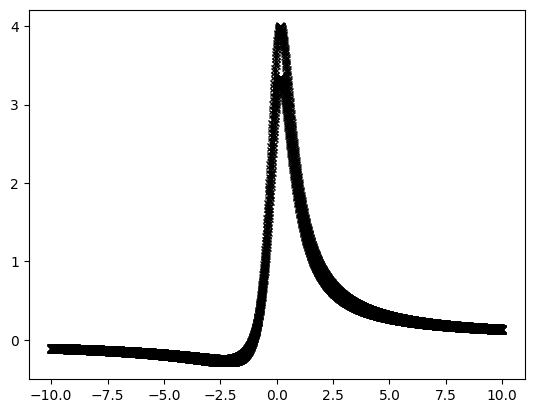

In [12]:
# for name, param in x_net.named_parameters():
#     print(f'Parameter name: {name}, Value: {param.data}')
plot_activation_function(x_net.activation_function1.lambda1.item(), x_net.activation_function1.lambda2.item(), x_net.activation_function1.d.item())
plot_activation_function(x_net.activation_function2.lambda1.item(), x_net.activation_function2.lambda2.item(), x_net.activation_function2.d.item())